# Analisis de datos de imagenes NDVI
Autor: Leonardo Bravo

Sintesis:

Se analizan imagenes NDVI utilizando servicio SentinelHhub usando libreria para python.

Se analizan 33 lotes diferentes durante 2016 a 2020.

Los principales insights obtenidos son:
- De acuerdo a los valores de NDVI para el tiempo analizado, se encuentran 2 principales grupos, (1) uno en el que sus valores de NDVI fluctuan entre 0.4 y 0.65, los cuales se definen como vegetación. El otro grupo (2) corresponde a un grupo en el que su NDVI varía desde valores inferiores a 0.2 para 2016, hasta valores cercanos a 0.4 para 2019.
- Para valores de NDVI se identifican posibles estacionalidades durante un año, encontrandose que NDVI varía entre máximos y mínimos locales durante el año.
- Para grupo (2), se encuentra que NDVI tiene tendencia de aumento en periodo analizado, cambiando su condición desde suelo (NDVI menor a 0,2) a vegetación (valor superior a 0,2).
- Se analiza relación informada entre NDVI y rendimiento, obteniéndose que con los datos obtenidos, no es posible definir claramente una relación entre estas variables. Además, se agrega variable "area" a analisis para intentar agregar variables explicatorias a rendimiento, pero esta no aporta mayor información.
- Para analizar relación informada entre NDVI y rendimiento, se implementa regresor lineal considerando solo NDVI y NDVI junto a area de lote. Para el primer caso se tuvo R2 de 0.52 y para el segundo, se obtuvo R2 de 0.54, los cuales no son considerados buenas métricas para una relación entre las variables.

# Obtener fechas de analisis

In [2]:
# getting .xlsx information of images
import pandas as pd
import numpy as np

# reading file
images_information = pd.read_excel('SentinelHubImage-available_dates.xlsx')

# print(images_information.head())
dates_to_analyze = np.unique(images_information._date.values)

# user message
print("N° fechas a analizar: ", dates_to_analyze.shape[0])
print("Fechas a analizar: \n", dates_to_analyze)

N° fechas a analizar:  89
Fechas a analizar: 
 ['2016-07-15' '2016-09-13' '2016-11-22' '2016-12-02' '2016-12-22'
 '2017-01-01' '2017-02-20' '2017-04-01' '2017-07-10' '2017-08-19'
 '2017-09-08' '2017-09-28' '2017-10-03' '2017-10-18' '2017-11-07'
 '2017-11-12' '2018-01-21' '2018-01-26' '2018-03-02' '2018-03-22'
 '2018-03-27' '2018-04-11' '2018-04-16' '2018-04-21' '2018-05-11'
 '2018-05-16' '2018-05-21' '2018-06-05' '2018-06-25' '2018-06-30'
 '2018-07-30' '2018-08-29' '2018-09-03' '2018-09-08' '2018-09-13'
 '2018-09-18' '2018-09-23' '2018-09-28' '2018-10-23' '2018-10-28'
 '2018-11-07' '2018-11-12' '2018-11-22' '2018-11-27' '2018-12-02'
 '2018-12-12' '2018-12-17' '2018-12-22' '2019-03-02' '2019-03-12'
 '2019-03-17' '2019-03-22' '2019-04-11' '2019-04-16' '2019-04-26'
 '2019-05-01' '2019-05-16' '2019-06-10' '2019-06-15' '2019-06-25'
 '2019-07-05' '2019-07-10' '2019-07-20' '2019-07-25' '2019-08-04'
 '2019-08-09' '2019-08-14' '2019-08-19' '2019-08-24' '2019-09-13'
 '2019-09-18' '2019-09-23' '2

# Para cada lote y fecha, obtener imagen NDVI

## Credenciales sentihub

In [3]:
# # setting sentinehub account
from sentinelhub import SHConfig

# instace hub
INSTANCE_ID = '4ddaf7ef-5547-43fd-b53c-16abbf76d393'  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

## Obteniendo coordenadas de lotes

In [4]:
import itertools
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString
from sentinelhub import BBoxSplitter, OsmSplitter, TileSplitter, CustomGridSplitter, UtmZoneSplitter, UtmGridSplitter
from sentinelhub import BBox, read_data, CRS, DataSource,WmsRequest, WcsRequest, MimeType

In [5]:
# get geojson data
INPUT_FILE = 'farm_map.json'

# read json file
geo_json = read_data(INPUT_FILE)

In [6]:
# defining lotes
lotes = geo_json["features"]

print("Lotes: ", len(lotes))

Lotes:  33


## Para cada lote y fecha, se obtiene image NDVI y su promedio NDVI

In [38]:
import time
from tqdm import tqdm_notebook

# store ndpi means
ndvi_means = np.zeros(shape = (len(lotes))*len(dates_to_analyze), )

# store dates
dates_ndvi_means = np.chararray(shape = (len(lotes))*len(dates_to_analyze), )

# store lotes ids
lotes_ids_ndvi = np.zeros(shape = (len(lotes))*len(dates_to_analyze), )

# create dataframe
ndvi_df = pd.DataFrame(columns=['lote_id', 'date', 'ndvi_mean'])

# Iterate through each lote
for idx_lote, lote in enumerate(tqdm_notebook(lotes)):    
    
    # get lote example area
    area = shape(lote["geometry"])
        
    # lote id
    lote_id = lote["properties"]["unit"]["id"]
    
    # Iterate through each date
    for idx_date, date in enumerate(tqdm_notebook(dates_to_analyze)):
        
        # split the area into smaller ones
        bbox_splitter = BBoxSplitter(
            [area], 
            CRS.WGS84, 
            (1, 1),# bounding box will be split into grid of 1x1 bounding boxes
            reduce_bbox_sizes=True, # reduce the area of box (it's to get the more exact area)
        )  
        
        # get bbox
        bbox = bbox_splitter.get_bbox_list()[0]
        
        # defining request
        wms_request = WmsRequest(
            
            # get NDVI band
            layer = "NDVI",
            
            # directory to download the data
            data_folder='/home/leo/Desktop/space-ag-data-analyst-challenge/images_official_1',
            
            # defining box
            bbox = bbox, 
            
            # defining date
            time = date,
            width=512,
            height=856,
            config=config,
            
        )

        # do requesting
        wms_image = wms_request.get_data(save_data=True)[0]
        
        # normalize data
        wms_image_norm = wms_image / 255.0
        
#         print("* original values: \n", wms_image_norm)
#         print("* normalized values: \n", wms_image[0]/255.)
        
        # get NDPI mean 
        ndpi_mean_norm = np.mean(wms_image_norm)
        ndpi_mean = np.mean(wms_image)
#         print(ndpi_mean)
        
        # create new row for dataframe
        ndvi_df = ndvi_df.append({
            'lote_id': lote_id, 
            'date': date, 
            'ndvi_mean_norm': ndpi_mean_norm,
            'ndvi_mean': ndpi_mean,
        }, ignore_index=True)
        
        # avoid blocking from API
#         print("pause")
#         time.sleep(10)

/home/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [43]:
# save the dataframe
ndvi_df.to_csv('NDVI_from_Images.csv', index=False)

## Comentarios:
- Dado el tiempo de desarrollo, no encontré mejor forma para poder trabajar con el poligono y hacer directamente el request. Asumo que quizás exista mejor forma.
- Tomó 7 horas en descargarse las imagenes (desconozco si es que se podría haber hecho de mejor manera) (quizás obtener todas la imágenes desde una sola request (como un batch), o quizás disminuir el tamaño de las imagenes (512, 816).

# Analisis de NDVI para cada lote en el tiempo

Información relevante:


1. NDVI valores de este índice van de -1 a 1.


2. A mayor valor de NDVI en un determinado pixel de la imagen entonces se espera una mayor biomasa del cultivo, es decir un cultivo más sano. 


3. A menores valores de NDVI se espera una menor biomasa o un área de vegetación o cultivo enferma.


4. Valores de vegetación están entre 0.2 a 1 de NDVI. 


5. Suelo generalmente tienen valores negativos de NDVI hasta valores de 0.2 en este índice. 


6. La presencia de nubes sobre el área evaluar afecta el promedio del NDVI.


7. Algunos agricultores de paltos piensan que puede existir una relación entre el NDVI con el rendimiento (Kg/Ha) del cultivo.

In [34]:
# Load dataset
# reading file
ndvi_df = pd.read_csv('NDVI_from_Images.csv')

# display dataframe
display(ndvi_df.head())

# check lotes number
lotes_ids = ndvi_df.lote_id.unique()

print("lotes: ", len(lotes_ids))

lote_id        date   ndvi_mean  ndvi_mean_norm
0    90214  2016-07-15  131.249738        0.514705
1    90214  2016-09-13  114.842059        0.450361
2    90214  2016-11-22  144.095185        0.565079
3    90214  2016-12-02  132.828556        0.520896
4    90214  2016-12-22  123.954706        0.486097

lotes:  33


## Analisis de todos los loteos

<IPython.core.display.Javascript object>


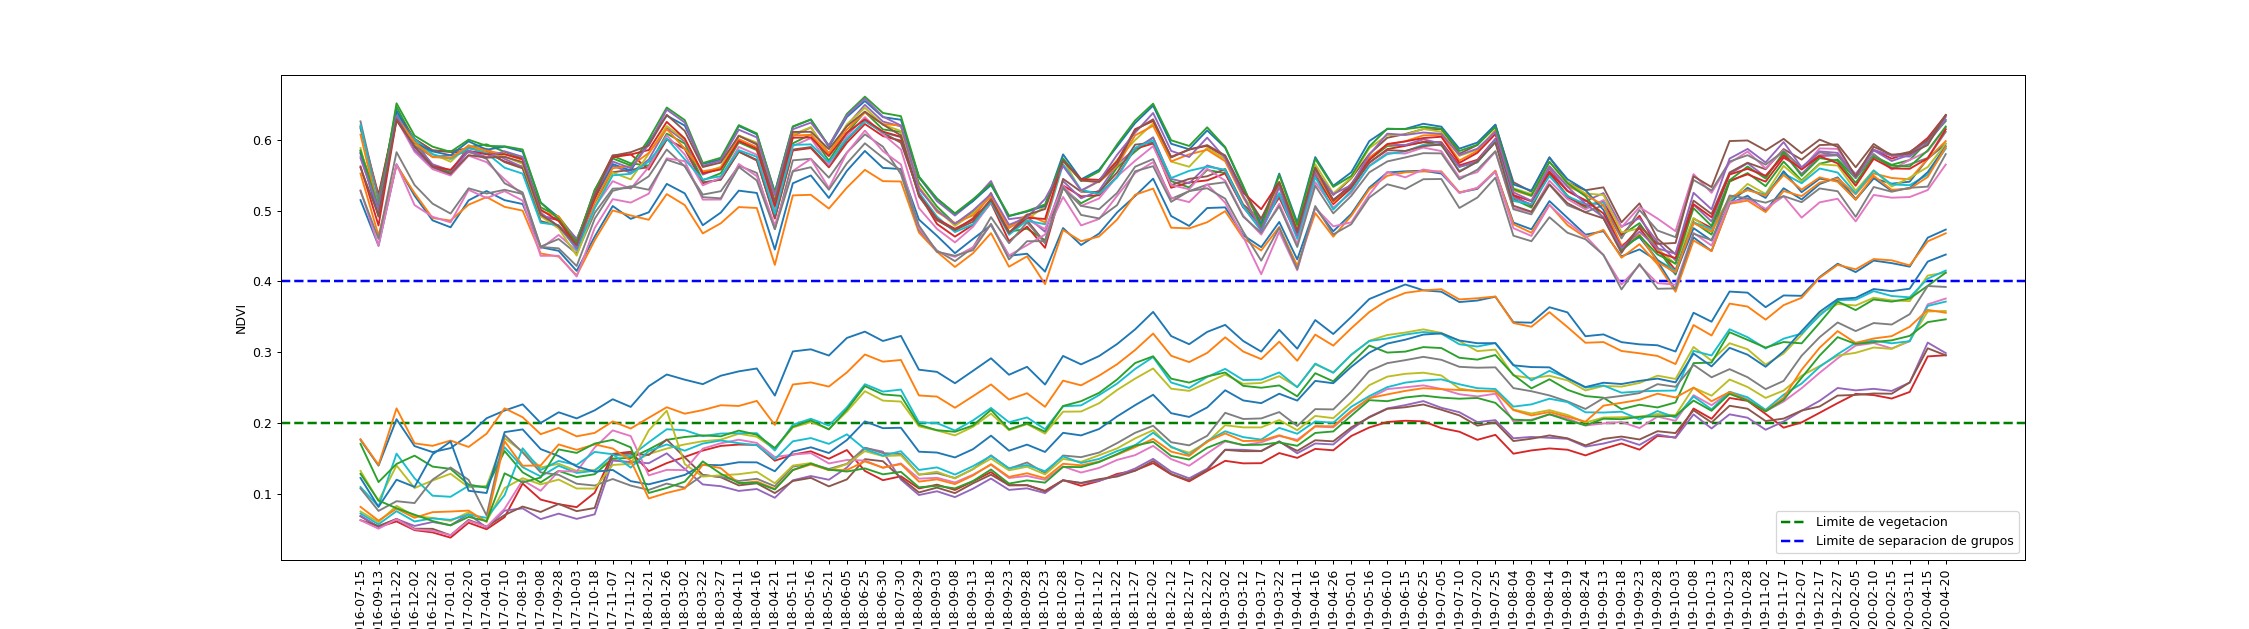

In [8]:
 # import library
import matplotlib.pyplot as plt

%matplotlib notebook 

# vegetation limits
vegetation_lower_limit = 0.2
vegetation_upper_limit = 1

# grund limit
ground_upper_limit = 0.2

# create plot
fig, ax = plt.subplots(figsize = (25,7))
#rotate x ticks
plt.xticks(rotation=90)
ax.set_xlabel("Fechas")
ax.set_ylabel("NDVI")

# plot vegetation limits
plt.axhline(y = vegetation_lower_limit, c = "g", lineWidth = 2, ls = '--', label = "Limite de vegetacion")
plt.axhline(y = 0.4, c = "b", lineWidth = 2, ls = '--', label = "Limite de separacion de grupos")

# # plot groun limit
# plt.axhline(y = ground_upper_limit)

# ploting each lote
for lote_id in lotes_ids:
    
    # ploting the data
    ax.plot(ndvi_df[ndvi_df.lote_id == lote_id].date, ndvi_df[ndvi_df.lote_id == lote_id].ndvi_mean_norm)
    
plt.legend()

## Comentarios:
- Se observan 2 grupos, uno con valores superiores a 0.4 (en su mayoría) y otro menor a 0.4 (Linea azul dibujada en gráfico).
- El grupo superior fluctua entre 0.4 y 0.6 durante el periodo analizado, pero no se observa tendencia a aumentar o disminuir su valor a largo plazo (ya que se mantien variando en este período).
- El grupo superior tiene en general una media que se mantiene similar entre todos los lotes sin mayores desviaciones, sin embargo, el grupo inferior presenta valores NDVI con mas variaciones entre lotes (valores de medias mas dispersos).
- Pareciera ser que existe una estacionalidad en los datos, en donde en el grupo superior es mas claro el comportamiento.
- El grupo inferior, fluctua entre 0.1 a 0.4 - 0.5, y se observa tendencia de aumento en el largo plazo.
- Se observa que a largo plazo, todos los lotes del grupo inferior alcanzaron un valor de NDVI superior a 0.2, lo que indica que evoluacionaron desde suelo (NDVI menor a 0.2) a vegetación (NDVI mayor a 0.2).
- En el grupo inferior, el tiempo en que loteos superan NDVI 0.2, varía, desde lotes que superan la condición en 1 año (lotes superiores del grupo inferior durante fechas 2016-07 a 2017-07) a 4 años (2016 hasta 2019).

## Analisis de loteos con NDVI superior a 0.2 (vegetación)

In [10]:
# Load dataset
# reading file

# mask for date
mask_date = ndvi_df["date"] == dates_to_analyze[0]

# mask for ndVI value
mask_ndvi = ndvi_df["ndvi_mean_norm"] > 0.4

# get lotes id
lotes_id_upper = ndvi_df[(mask_date & mask_ndvi)].lote_id.values

# get df with upper values
ndvi_df_upper = ndvi_df.loc[ndvi_df['lote_id'].isin(lotes_id_upper)]

## Analisis de NDVI y temporalidad

<IPython.core.display.Javascript object>


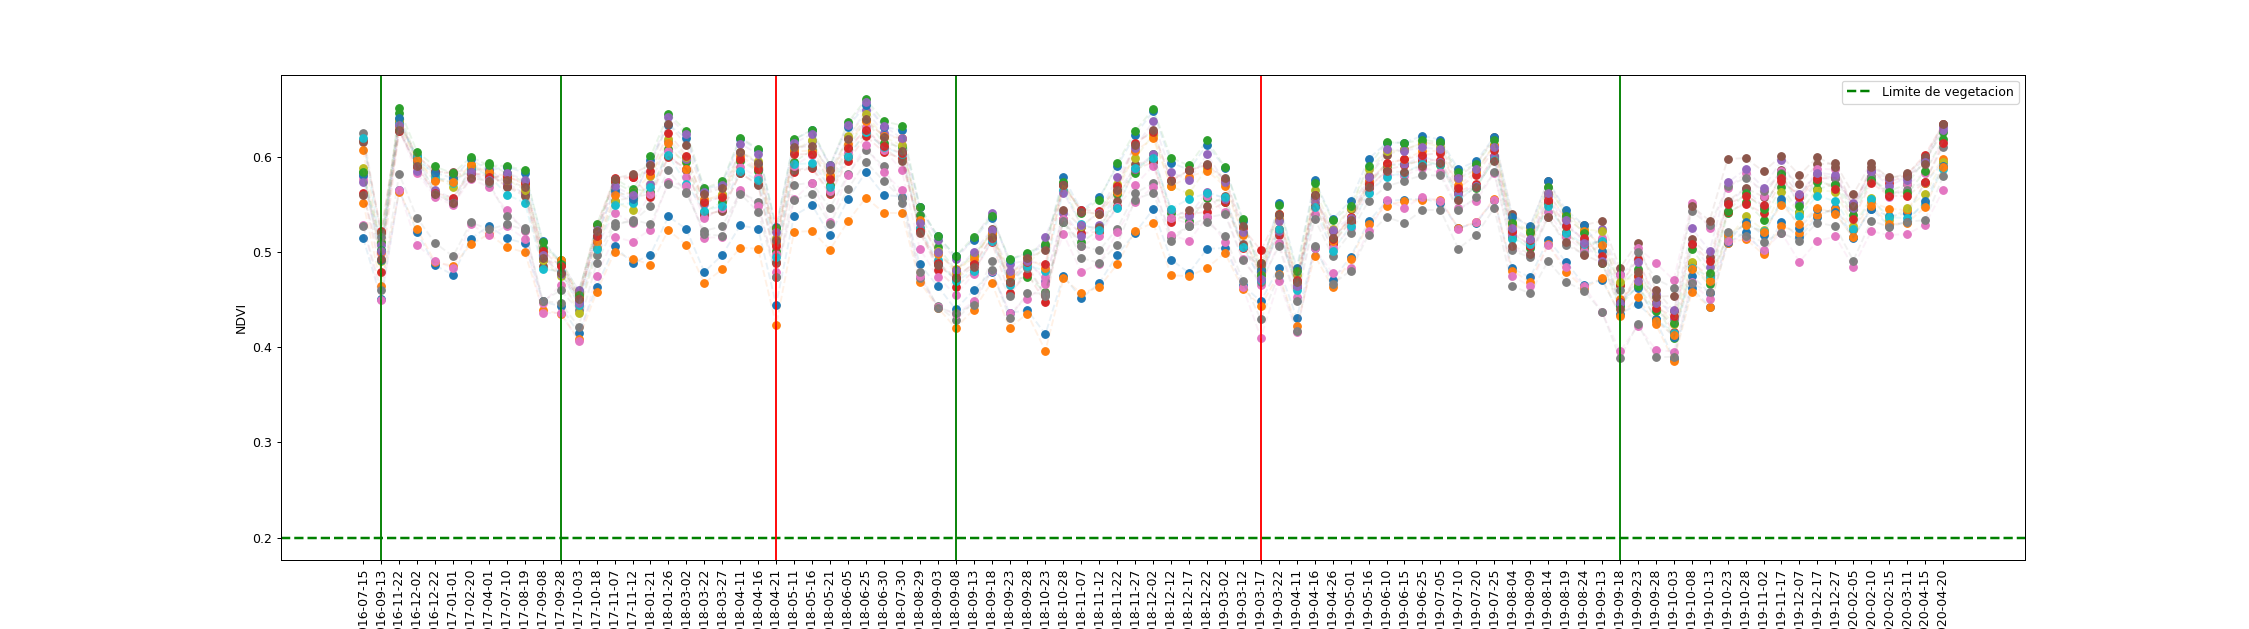

In [11]:
# plotting
# import library
import matplotlib.pyplot as plt

# vegetation limits
vegetation_lower_limit = 0.2
vegetation_upper_limit = 1

# grund limit
ground_upper_limit = 0.2

# create plot
fig, ax = plt.subplots(figsize = (25,7))
#rotate x ticks
plt.xticks(rotation=90)
ax.set_xlabel("Fechas")
ax.set_ylabel("NDVI")

# plot vegetation limits
plt.axhline(y = vegetation_lower_limit, c = "g", lineWidth = 2, ls = '--', label = "Limite de vegetacion")
# plt.axhline(y = 0.4, c = "b", lineWidth = 2, ls = '--', label = "Limite de separacion de grupos")

# plot "minimus" in curve
plt.axvline(x=1, c = "g")
plt.axvline(x=11, c = "g")
plt.axvline(x=23, c = "r")
plt.axvline(x=33, c = "g")
plt.axvline(x=50, c = "r")
plt.axvline(x=70, c = "g")

# ploting each lote
for lote_id in lotes_id_upper:
    
    # ploting the data
    ax.scatter(ndvi_df_upper[ndvi_df_upper.lote_id == lote_id].date, ndvi_df_upper[ndvi_df_upper.lote_id == lote_id].ndvi_mean_norm)
    ax.plot(ndvi_df_upper[ndvi_df_upper.lote_id == lote_id].date, ndvi_df_upper[ndvi_df_upper.lote_id == lote_id].ndvi_mean_norm, '--', alpha = 0.1)
    
plt.legend()

## Comentarios:
- Se tiene que valores de estos lotes se mantuvieron dentro de rango 0.4 a 0.65 dentro del periodo analizado.
- Se observa temporalidad de NDVI, en donde las lineas verdes representan minimos locales encontrados para el mes 9 (Octubre), los cuales se presentan todos los años (todos los años se tiene un mínimo de NDVI para Octubre).
- Las lineas rojas representan mínimos locales encontrados para el mes 3 o 4 (Marzo y Abril), la que se presentan para 2018 y 2019.

## Analisis para 1 año (2018)

In [12]:
# define new df
ndvi_df_upper_year = ndvi_df_upper.copy()

# define column as date
ndvi_df_upper_year['date'] = pd.to_datetime(ndvi_df_upper['date'])

# set date as index
ndvi_df_upper_year.set_index('date', inplace=True)

# get 2018 measurements
ndvi_df_upper_year = ndvi_df_upper_year.loc['2018-01-01':'2018-12-30']

# display df
display(ndvi_df_upper_year.head())

lote_id   ndvi_mean  ndvi_mean_norm
date                                           
2018-01-21    90214  126.851145        0.497455
2018-01-26    90214  137.081358        0.537574
2018-03-02    90214  133.673112        0.524208
2018-03-22    90214  122.202297        0.479225
2018-03-27    90214  126.765639        0.497120

<IPython.core.display.Javascript object>


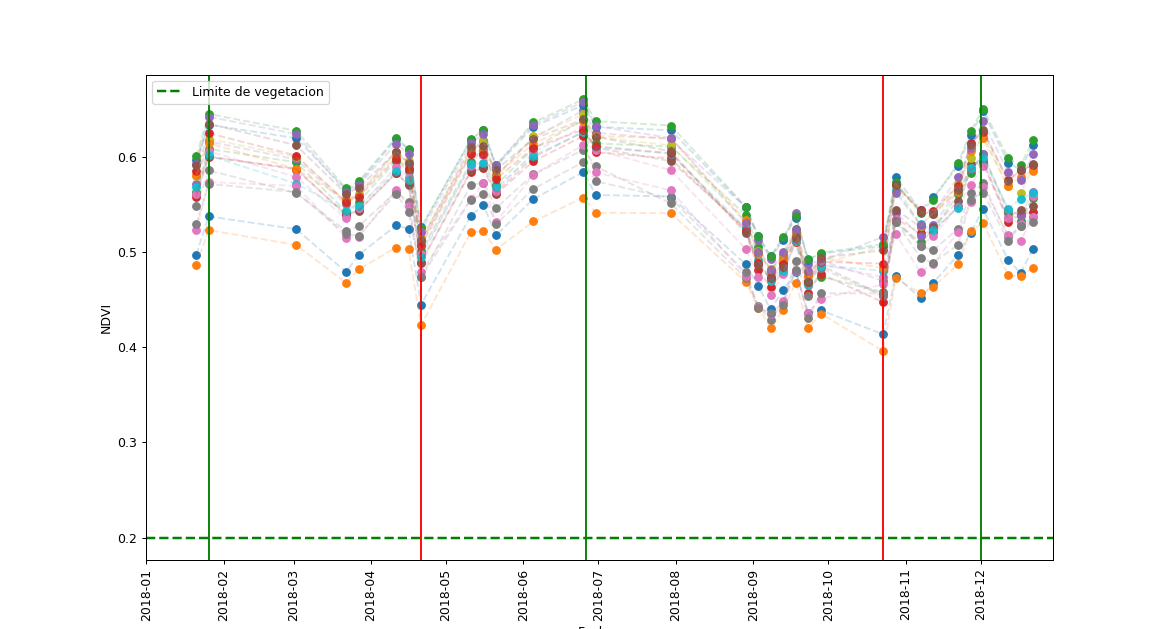

(736695.0, 737058.0)

In [13]:
import datetime

# vegetation limits
vegetation_lower_limit = 0.2
vegetation_upper_limit = 1

# grund limit
ground_upper_limit = 0.2

# create plot
fig, ax = plt.subplots(figsize = (13,7))
#rotate x ticks
plt.xticks(rotation=90)
ax.set_xlabel("Fechas")
ax.set_ylabel("NDVI")

# plot vegetation limits
plt.axhline(y = vegetation_lower_limit, c = "g", lineWidth = 2, ls = '--', label = "Limite de vegetacion")

# plot "minimum" in curve
plt.axvline(x= datetime.date(2018, 4, 21), c = "r")
plt.axvline(x= datetime.date(2018, 10, 23), c = "r")

# plot "maximum" in curve
plt.axvline(x= datetime.date(2018, 1, 26), c = "g")
plt.axvline(x= datetime.date(2018, 6, 26), c = "g")
plt.axvline(x= datetime.date(2018, 12, 1), c = "g")


# ploting each lote
for lote_id in lotes_id_upper:
    
    # ploting the data
    ax.scatter(ndvi_df_upper_year[ndvi_df_upper_year.lote_id == lote_id].index, ndvi_df_upper_year[ndvi_df_upper_year.lote_id == lote_id].ndvi_mean_norm)
    ax.plot(ndvi_df_upper_year[ndvi_df_upper_year.lote_id == lote_id].index, ndvi_df_upper_year[ndvi_df_upper_year.lote_id == lote_id].ndvi_mean_norm, '--', alpha = 0.2)
    
plt.legend()
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 30)])

## Comentarios:
- En el gráfico se marcan los maximos locales con verde y los minimos locales con rojo. Desde lo anterior, se tiene el siguiente patrón anual para NDVI:
    1. NDVI alcanza maximo local en Febrero.
    2. Luego, disminuye progresivamente hasta alcanzar un mínimo local en Abril-Mayo.
    3. Luego empieza a aumentar hasta alcanzar máximo local en Julio. 
    4. Luego disimimuye alcanzando minimo local en Octubre.
    4. Luego aumenta hasta alcanzar máximo local en Diciembre.
    
    
- La estacionalidad anterior es válida solo para 2018, ya que al observar datos para 2017 y 2019, no se cumple la mismas fechas. Sin embargo, tambine se da estacionalidad, encontrandose valores de NDVI que varian en minimos y maximos locales durante diferentes tiempos del año.

## Analisis de loteos con NDVI inferior a 0.2 (suelos)

In [14]:
# Load dataset
# reading file

# mask for date
mask_date = ndvi_df["date"] == dates_to_analyze[0]

# mask for ndVI value
mask_ndvi = ndvi_df["ndvi_mean_norm"] < 0.4

# get lotes id
lotes_id_lower = ndvi_df[(mask_date & mask_ndvi)].lote_id.values

# get df with upper values
ndvi_df_lower = ndvi_df.loc[ndvi_df['lote_id'].isin(lotes_id_lower)]

<IPython.core.display.Javascript object>


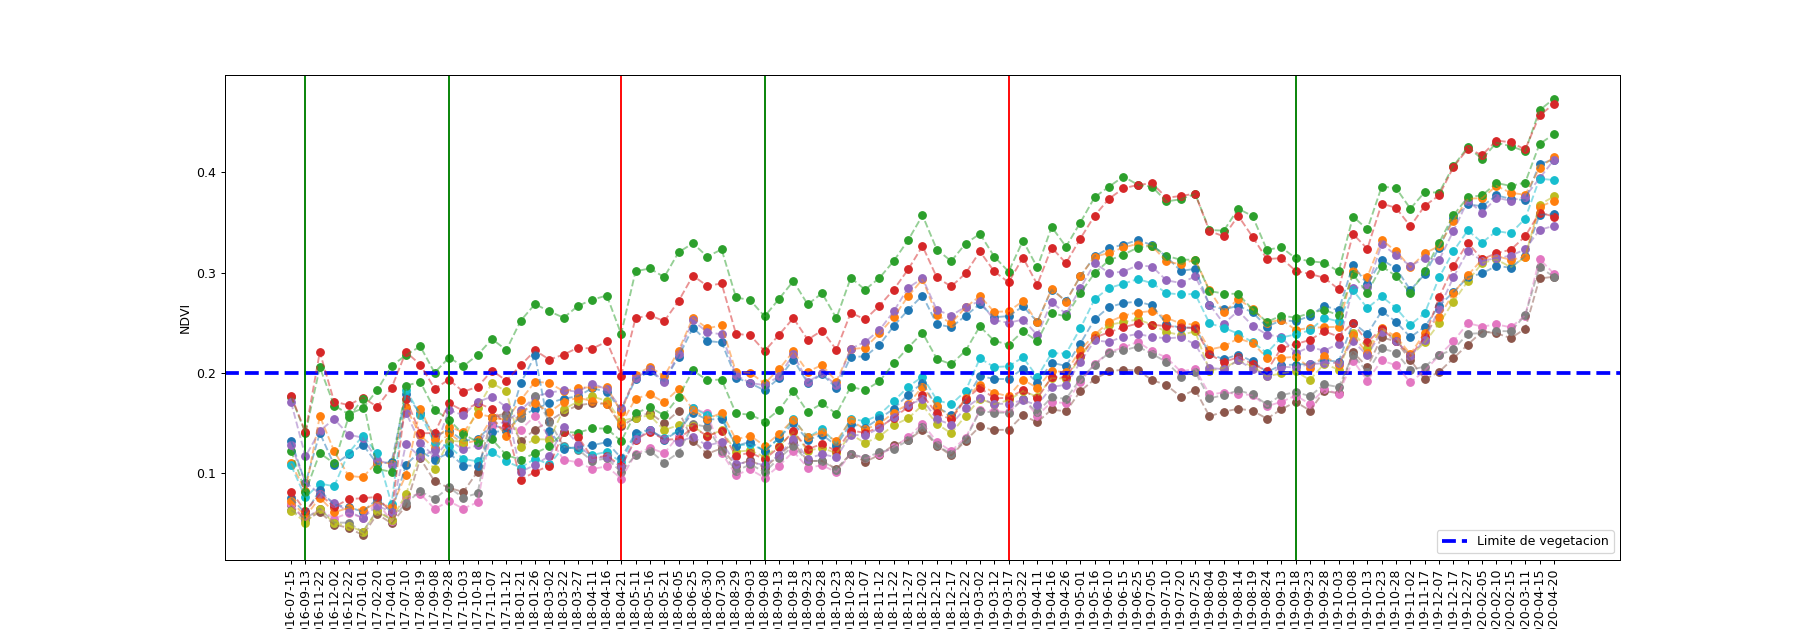

In [15]:
# plotting
# import library
# import matplotlib.pyplot as plt

# vegetation limits
vegetation_lower_limit = 0.2
vegetation_upper_limit = 1

# grund limit
ground_upper_limit = 0.2

# create plot
fig, ax = plt.subplots(figsize = (20,7))
#rotate x ticks
plt.xticks(rotation=90)
ax.set_xlabel("Fechas")
ax.set_ylabel("NDVI")

# plot vegetation limits
plt.axhline(y = vegetation_lower_limit, c = "b", lineWidth = 3, ls = '--', label = "Limite de vegetacion")
# plt.axhline(y = 0.4, c = "b", lineWidth = 2, ls = '--', label = "Limite de separacion de grupos")

# plot "minimus" in curve
plt.axvline(x=1, c = "g")
plt.axvline(x=11, c = "g")
plt.axvline(x=23, c = "r")
plt.axvline(x=33, c = "g")
plt.axvline(x=50, c = "r")
plt.axvline(x=70, c = "g")

# ploting each lote
for lote_id in lotes_id_lower:
    
    # ploting the data
    ax.scatter(ndvi_df_lower[ndvi_df_lower.lote_id == lote_id].date, ndvi_df_lower[ndvi_df_lower.lote_id == lote_id].ndvi_mean_norm)
    ax.plot(ndvi_df_lower[ndvi_df_lower.lote_id == lote_id].date, ndvi_df_lower[ndvi_df_lower.lote_id == lote_id].ndvi_mean_norm, '--', alpha = 0.5)
    
plt.legend()

## Comentarios:
- Del gráfico se puede ver que es mas confuso analizar la estacionalidad, pero que los mínimos se presentan al igual que en los casos de lotes con valores superiores de NDVI.
- Al igual que comentarios anteriores, se observa la evolución de valor NDVI para los lotes, en donde durante el período analizado, la tendencia a largo plazo corresponde a un aumento en su valor, sobrepasando el limite de vegetación.

# Analisis Rendimiento cultivo y NDVI
Dado que agricultores informan posible relacion, entre NDVI y Rendimiento, se analiza posible relación.

In [96]:
# check all the are the same
prior_date = ""
prior_variety = ""

for lote in lotes:
    
    # get prior values
    prior_date = lote["properties"]["values"][0]["date_stamp"]
    prior_variety = lote["properties"]["unit"]["state"]["variety"]
    
    # check date
    if prior_date != lote["properties"]["values"][0]["date_stamp"]:
        print("Not same date")
    
    # check variety is the smae
    if prior_variety != lote["properties"]["unit"]["state"]["variety"]:
        print("Not same variety")
        
# date to analyze
date_to_analyze = lote["properties"]["values"][0]["date_stamp"]
print("Fecha a analizar: ", date_to_analyze)

Fecha a analizar:  2019-09-19


In [100]:
# get lote yield of each lote

# yield array
yields = np.zeros((len(lotes), 2))

# create new df
ndvi_yield_df = pd.DataFrame(columns=['lote_id', 'area', 'ndvi', 'yield'])

# iterate
for lote in lotes:
    
    # get lote id
    lote_id_ = lote["properties"]["unit"]["id"]
    
    # get yield
    yield_ =  lote["properties"]["values"][0]["value"] 
    
    # get ndvi value
    ndvi = ndvi_df[ndvi_df.lote_id == lote_id_].ndvi_mean_norm.values[0]
    
    # get area
    area = lote["properties"]["unit"]["state"]["area"]
    
    # create new row for dataframe
    ndvi_yield_df = ndvi_yield_df.append({
        'lote_id': lote_id_, 
        'area': area,
        "yield": yield_,
        "ndvi": ndvi,
    }, ignore_index=True)

<IPython.core.display.Javascript object>


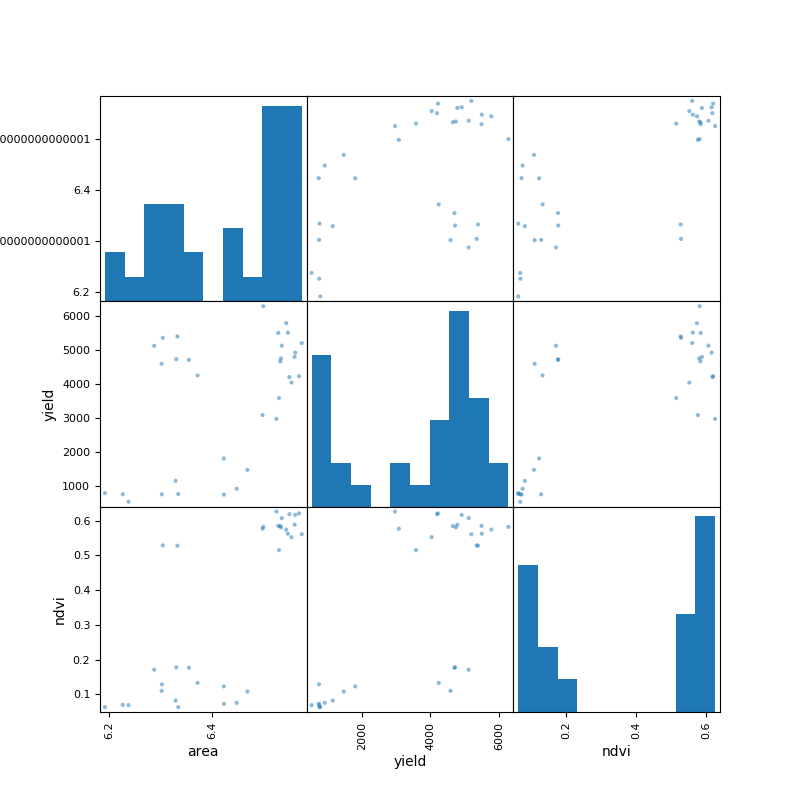

In [104]:
# Analyze relation

# load specific function
from pandas.plotting import scatter_matrix

# display the scatter matrix
scatter_matrix(ndvi_yield_df.loc[:, ["area", "yield", "ndvi"]], diagonal="hist", figsize = (8, 8));

## Comentarios:
- Desde el gráfico de yield en función de ndvi, se observa que existen 3 grupos:
    1. Bajo valor de ndvi (menor a 0.2) y bajo valor de rendimiento (menor a 2.000).
    2. Alto valor de ndvi (superior a 0.2) y alto valor de rendimiento (superior a 2.000).
    3. Bajo valor de ndvi (menor a 0.2) y alto valor de rendimiento (superior a 2.000).
- De lo anterior se tiene, que si bien existe grupos en donde se cumple relacion directamente proporcional entre NDVI y rendimiento (grupo 1 y 2), existe un grupo en donde no se cumple esta relación, lo que impide generalizar la relación. 
- Sin embargo, quizás se podrian analizar mas datos para invetigar si es que el grupo 3 posee valor de alguna variable no analizada acá, que genera que sea un grupo que no cumple la relación.

## Analisis de grupos (3 grupos diferentes)

In [151]:
# mask for ndvi values
mask_ndvi = ndvi_yield_df.ndvi > 0.2

# mask for yield
yield_mask = ndvi_yield_df["yield"] > 2000

# get data
cluster_data = ndvi_yield_df.copy()

# get 1 group (ndvi < 0.2 and yield < 2.000)
cluster_data.loc[((~mask_ndvi) & (~yield_mask)), "group"] = 1

# get 2 group (ndvi > 0.2 and yield > 2.000)
cluster_data.loc[(mask_ndvi & yield_mask), "group"] = 2

# get 3 group (ndvi < 0.2 and yield > 2.000)
cluster_data.loc[((~mask_ndvi) & yield_mask), "group"] = 3

cluster_data.head()

lote_id      area      ndvi        yield  group
0  90214.0  6.530601  0.514705  3581.158766    2.0
1  90215.0  6.555069  0.552122  4037.375179    2.0
2  90216.0  6.533254  0.584079  4658.420440    2.0
3  90217.0  6.551013  0.618101  4196.272166    2.0
4  90218.0  6.534646  0.580255  4744.580970    2.0

<IPython.core.display.Javascript object>


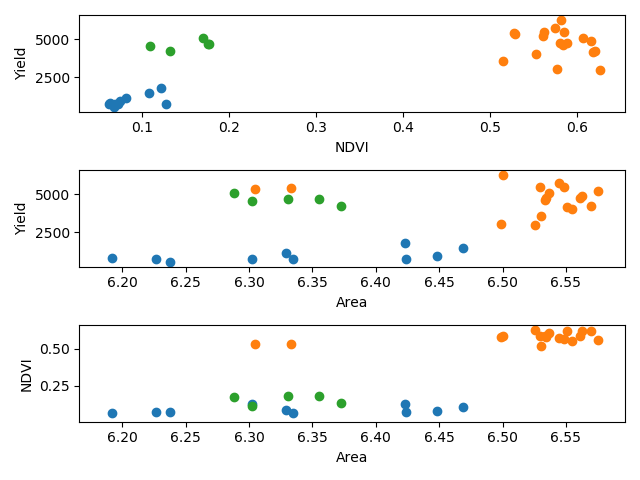

In [161]:
# plot

# define plot 
fig, ax = plt.subplots(3, 1, tight_layout = True)

for group in range(1, 4):

    # NDVI v/s Yield
    idx = 0
    ax[idx].set_xlabel("NDVI")
    ax[idx].set_ylabel("Yield")
    ax[idx].scatter(
        cluster_data[cluster_data["group"] == group]["ndvi"], 
        cluster_data[cluster_data["group"] == group]["yield"], 
    )
#     ax[idx].scatter(cluster_data[cluster_data["group"] == group]["ndvi"], cluster_data[cluster_data["group"] == group]["yield"], c= "b")

    # Area v/s Yield
    idx = 1
    ax[idx].set_xlabel("Area")
    ax[idx].set_ylabel("Yield")
    ax[idx].scatter(cluster_data[cluster_data["group"] == group]["area"], cluster_data[cluster_data["group"] == group]["yield"])
#     ax[idx].scatter(outlayer_data["area"], outlayer_data["yield"], c= "r")

    # Area v/s NDVI
    idx = 2
    ax[idx].set_xlabel("Area")
    ax[idx].set_ylabel("NDVI")
    ax[idx].scatter(cluster_data[cluster_data["group"] == group]["area"], cluster_data[cluster_data["group"] == group]["ndvi"])
#     ax[idx].scatter(outlayer_data["area"], outlayer_data["ndvi"], c= "r")

# plt.legend()

## Comentarios
- Del primer gráfico se tiene que grupo verde es quien genera que la relación no sea evidente, ya que a bajo valor de NDPI, se tiene alto valor de rendimiento.
- Al observar 2 gráfico, se tiene que grupo azul y naranjo se logran diferencia facilmente (sin embargo se tienen 2 puntos que para mismos valores de area, se tienen diferentes valores de rendimiento). Sin embargo, grupo verde se separa de los otros dos, pero no es clara la relación enre rendimieto y área, ya que para mismo valor de area, se tienen diferentes valores de rendmiento (puede ser de grupo azul y verde) (area de 6.35).
- Del 3 gráfico tampoco es clara la relación de las variables.
- De lo anterior, no es posible determinar claramente la relación entre NDPI y rendimiento, ya que existen datos que dificultan la determinación del tipo de relación.
- Una posible causa de esta problemática (de no poder determinar la relación que se informa), es que quizás falten variables a considerar en el modelo, ya que quizás esta otra variable podría ayudar a explicar el modelo

<IPython.core.display.Javascript object>


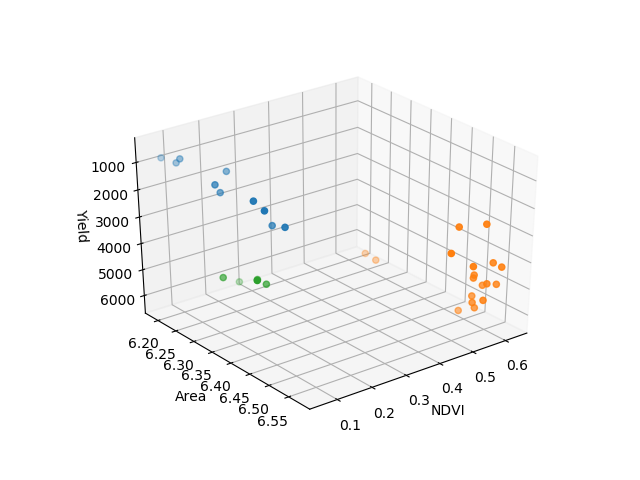

In [167]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# 3D plot
# fig, ax = plt.subplots(tight_layout = True,projection='3d')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("NDVI")
ax.set_ylabel("Area")
ax.set_zlabel("Yield")

for group in range(1, 4):
    
    ax.scatter(
        cluster_data[cluster_data["group"] == group]["ndvi"], 
        cluster_data[cluster_data["group"] == group]["area"], 
        cluster_data[cluster_data["group"] == group]["yield"], 
    )

## Comentarios
- Del gráfico 3D se observa la distribucion de clusters pero tampoco es posible definir una relacion clara de variables.

# Definición Regresión Lineal
Como se informa posible relacióne entre NDVI y Rendimiento, se implementa regresor lineal analizando sus métricas

In [176]:
# format data 

# variables: "ndvi", "area"
X_uni = cluster_data.loc[:, ["ndvi"]]
X_multi = cluster_data.loc[:, ["ndvi", "area"]]

y = cluster_data.loc[:, ["yield"]]

# # plot variables
# fig, ax = plt.subplots()
# ax.scatter(X, y)

In [177]:
from sklearn.linear_model import LinearRegression

# Define model
regressor_uni = LinearRegression()
regressor_multi = LinearRegression()

# train the linear regressor
regressor_uni.fit(X_uni, y)
regressor_multi.fit(X_multi, y)

# get R2 score
# the more close to 1 is, the better the model fit the data
print("univariable regresor R2: ", regressor_uni.score(X_uni, y))
print("multivariable regresor R2: ", regressor_multi.score(X_multi, y))

univariable regresor R2:  0.5288598754097731
multivariable regresor R2:  0.5455996257925375


## Comentarios
- Se obtiene R2 score de 0.52 para regresor univariado, el cual no es buena métrica para un regresor (idealmente cercano a 1).
- Se obtiene R2 score de 0.54 para regresor multivariado, el cual tampoco es buena métrica.
- El agregar la variable "area" aumenta el R2, pero de forma muy pequeña.